# Validation for quantile scaling

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import cmocean

sys.path.append('/home/599/dbi599/qq-workflows')
import validation
sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/QQ-comparison/ACCESS-ESM1-5/ssp370/r6i1p1f1/day/pr/qdm/pr-qdm-multiplicative-q100-adjustment-factors_ACCESS-ESM1-5_ssp370_r6i1p1f1_gn_20700101-20991231_wrt_19850101-20141231.nc"
qq_file = "/g/data/wp00/users/dbi599/QQ-comparison/ACCESS-ESM1-5/ssp370/r6i1p1f1/day/pr/qdm/pr_day_ACCESS-ESM1-5_ssp370_r6i1p1f1_AUS-r005_20700101-20991231_qdm-multiplicative-q100-nearest_AGCD-19850101-20141231_historical-19850101-20141231.nc"
hist_units = "kg m-2 s-1"
ref_units = "kg m-2 s-1"
target_units = "mm day-1"
output_units = "mm day-1"
hist_var = "pr"
ref_var = "pr"
target_var = "precip"
scaling = "multiplicative"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r6i1p1f1_gn_18500101-18991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r6i1p1f1_gn_19000101-19491231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r6i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r6i1p1f1_gn_20000101-20141231.nc"
ref_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r6i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r6i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r6i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r6i1p1f1_gn_20650101-21001231.nc"
target_files = "/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19000101-20220405_daily_space-chunked.zarr"
hist_time_bounds = "1985-01-01 2014-12-31"
ref_time_bounds = "2070-01-01 2099-12-31"
target_time_bounds = "1985-01-01 2014-12-31"


In [3]:
# Required parameters
assert 'scaling' in locals(), "Must provide the scaling method (option -p scaling {name})"
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [4]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

In [5]:
plot_config = {}
plot_config['plot_pdfs_flag'] = True
plot_config['plot_1d_quantiles_flag'] = True
mask_ocean = True
if hist_var == 'tasmin':
    plot_config['pdf_xbounds'] = (-5, 30)
    plot_config['pdf_ybounds'] = None
    plot_config['q_xbounds'] = (0, 100)
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [-4.0, -2.5, -1, 0.5, 2, 3.5, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17, 18.5, 20, 21.5]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [-2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5]
    clim_extend = 'both'
elif hist_var == 'tasmax':
    plot_config['pdf_xbounds'] = (0, 45)
    plot_config['pdf_ybounds'] = None
    plot_config['q_xbounds'] = (0, 100)
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [-2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5]
    clim_extend = 'both'
elif hist_var == 'pr':
    plot_config['plot_pdfs_flag'] = False
    plot_config['pdf_xbounds'] = (5, 80)
    plot_config['pdf_ybounds'] = (0, 0.02)
    plot_config['q_xbounds'] = (80, 100)
    plot_config['regular_cmap'] = cmocean.cm.rain
    plot_config['diverging_cmap'] = 'BrBG'
    plot_config['general_levels'] = [0, 0.01, 0.25, 0.5, 1, 2, 5, 10, 20, 40, 60]
    plot_config['af_levels'] = [0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
    plot_config['difference_levels'] = [-65, -55, -45, -35, -25, -15, -5, 5, 15, 25, 35, 45, 55, 65]
    clim_extend = 'max'
else:
    raise ValueError(f'No plotting configuration defined for {hist_var}')

In [6]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

## Read data

In [7]:
ds_adjust = xr.open_dataset(adjustment_file)

In [8]:
if 'month' in ds_adjust.dims:
    plot_config['plot_2d_quantiles_flag'] = True
    plot_config['months'] = [1,2,3,4,5,6,7,8,9,10,11,12]
else:
    plot_config['plot_2d_quantiles_flag'] = False
    plot_config['months'] = []

In [9]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)

In [10]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)

In [11]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

In [12]:
ds_qq = xr.open_dataset(qq_file)

## Australia-wide

In [13]:
hist_clim = ds_hist[hist_var].mean('time', keep_attrs=True).compute()
ref_clim = ds_ref[ref_var].mean('time', keep_attrs=True).compute()
target_clim = ds_target[target_var].mean('time', keep_attrs=True).compute()
qq_clim = ds_qq[target_var].mean('time', keep_attrs=True).compute()

#### QDM

GCM change = ref (ssp) - hist  
QQ change = qq - target (obs)

#### eCDFm

GCM change = target (ssp) - hist  
QQ change = qq - ref (obs)

In [14]:
ref_hist_comparison = validation.spatial_comparison_data(ref_clim, hist_clim, scaling)
qq_target_comparison = validation.spatial_comparison_data(qq_clim, target_clim, scaling)
target_hist_comparison = validation.spatial_comparison_data(target_clim, hist_clim, scaling)
qq_ref_comparison = validation.spatial_comparison_data(qq_clim, ref_clim, scaling)

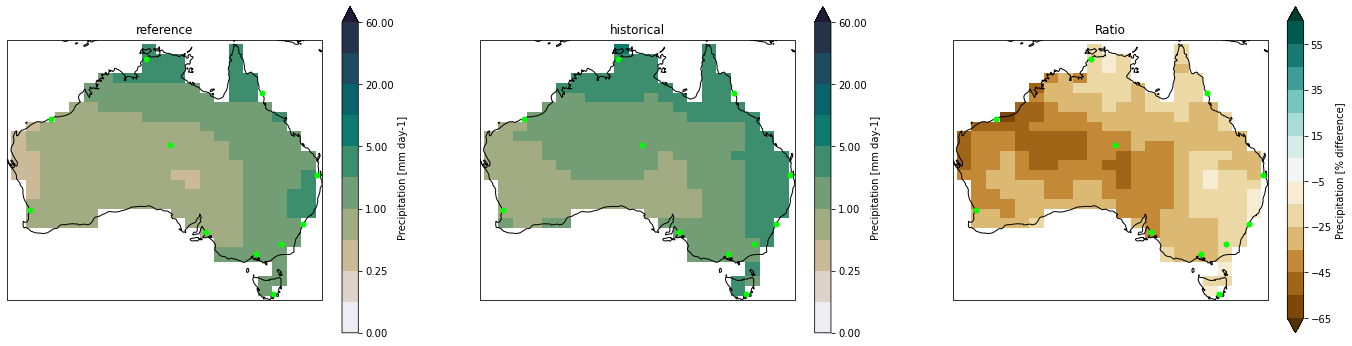

In [15]:
validation.spatial_comparison_plot(
    ref_clim,
    hist_clim,
    ref_hist_comparison,
    'reference',
    'historical',
    plot_config['regular_cmap'],
    plot_config['diverging_cmap'],
    plot_config['general_levels'],
    plot_config['difference_levels'],
    scaling,
    city_lat_lon=city_lat_lon,
    land_only=mask_ocean,
    clim_extend=clim_extend,
)

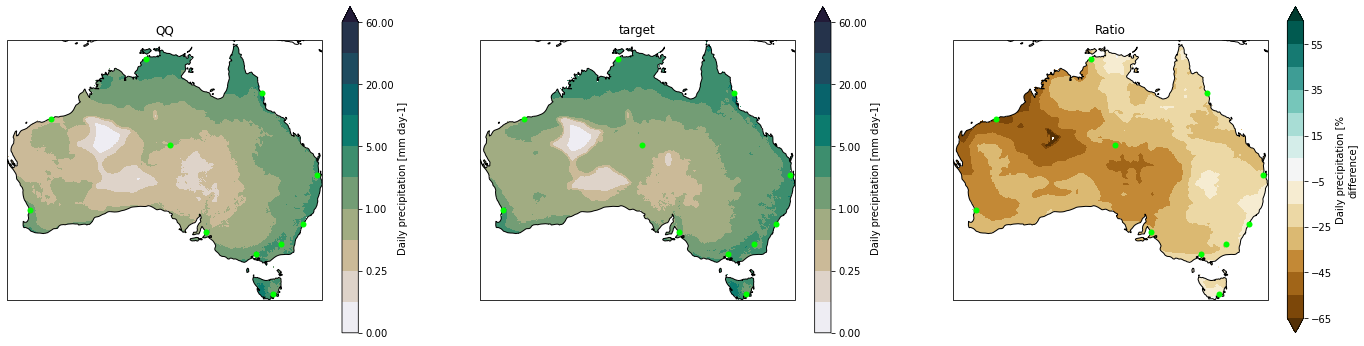

In [16]:
validation.spatial_comparison_plot(
    qq_clim,
    target_clim,
    qq_target_comparison,
    'QQ',
    'target',
    plot_config['regular_cmap'],
    plot_config['diverging_cmap'],
    plot_config['general_levels'],
    plot_config['difference_levels'],
    scaling,
    city_lat_lon=city_lat_lon,
    land_only=mask_ocean,
    clim_extend=clim_extend,
)

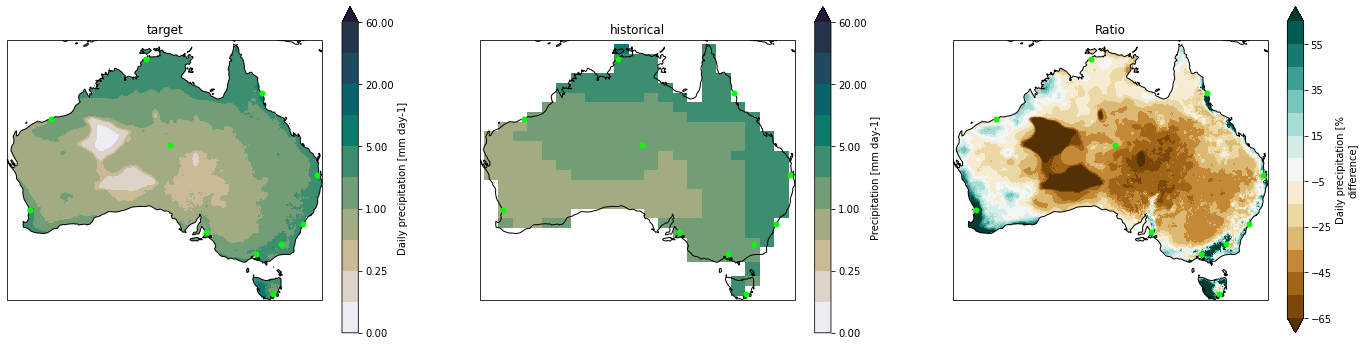

In [17]:
validation.spatial_comparison_plot(
    target_clim,
    hist_clim,
    target_hist_comparison,
    'target',
    'historical',
    plot_config['regular_cmap'],
    plot_config['diverging_cmap'],
    plot_config['general_levels'],
    plot_config['difference_levels'],
    scaling,
    city_lat_lon=city_lat_lon,
    land_only=mask_ocean,
    clim_extend=clim_extend
)

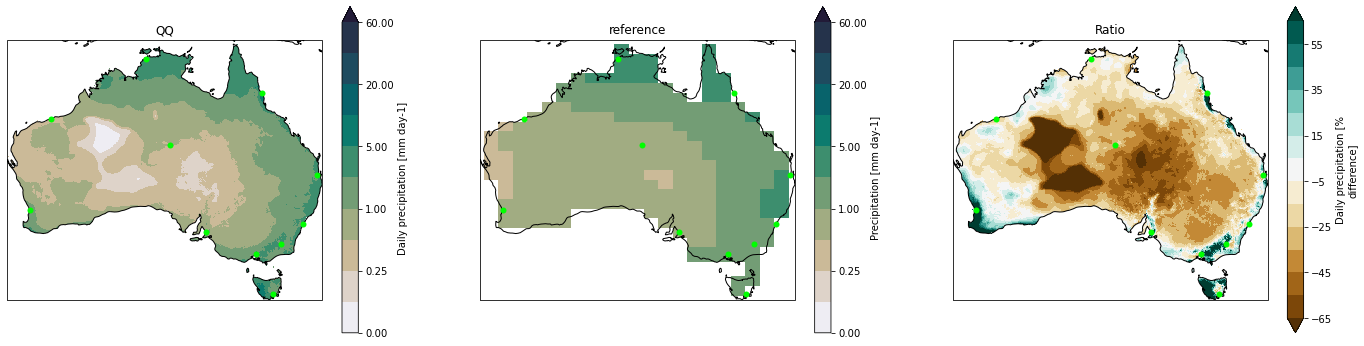

In [18]:
validation.spatial_comparison_plot(
    qq_clim,
    ref_clim,
    qq_ref_comparison,
    'QQ',
    'reference',
    plot_config['regular_cmap'],
    plot_config['diverging_cmap'],
    plot_config['general_levels'],
    plot_config['difference_levels'],
    scaling,
    city_lat_lon=city_lat_lon,
    land_only=mask_ocean,
    clim_extend=clim_extend
)

## Points of interest

In [19]:
def plot_city(city):
    """Generate plots for a city"""
    
    lat, lon = city_lat_lon[city]
    
    validation.single_point_analysis(
        ds_hist[hist_var],
        ds_ref[ref_var],
        ds_target[target_var],
        ds_qq[target_var],
        ds_adjust,
        hist_var,
        city,
        lat,
        lon,
        plot_config['regular_cmap'],
        plot_config['diverging_cmap'],
        plot_config['general_levels'],
        plot_config['af_levels'],
        pdf_xbounds=plot_config['pdf_xbounds'],
        pdf_ybounds=plot_config['pdf_ybounds'],
        q_xbounds=plot_config['q_xbounds'],
        months=plot_config['months'],
        plot_1d_quantiles=plot_config['plot_1d_quantiles_flag'],
        plot_2d_quantiles = plot_config['plot_2d_quantiles_flag'],
        plot_pdfs=plot_config['plot_pdfs_flag'],
        seasonal_agg='mean',
    )

HOBART


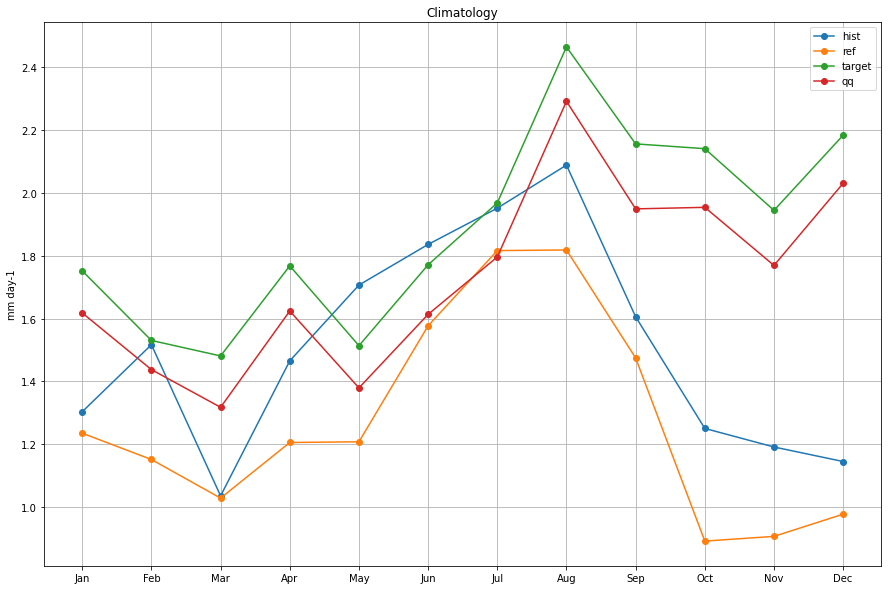

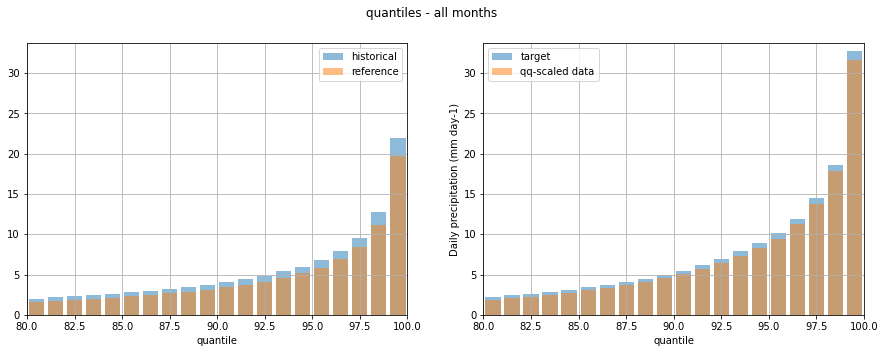

In [20]:
plot_city('Hobart')

MELBOURNE


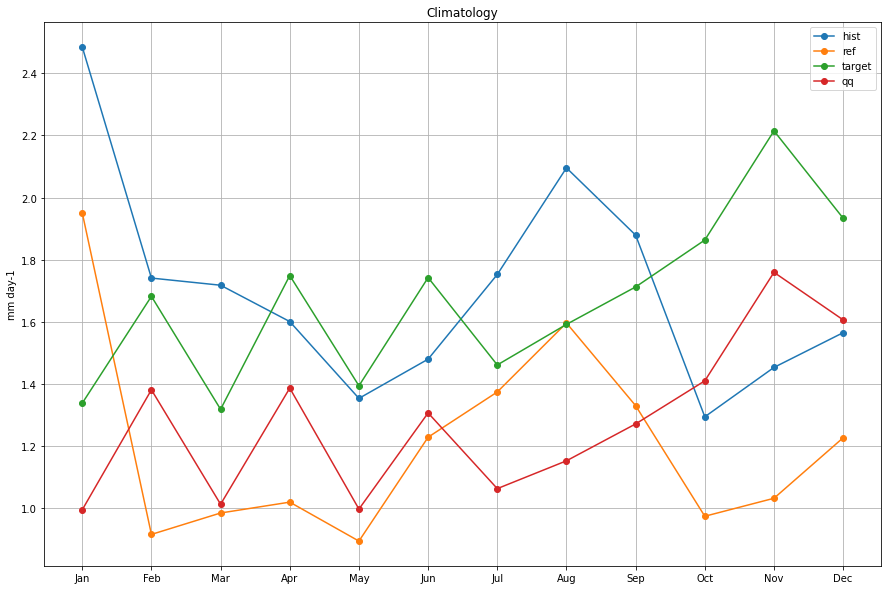

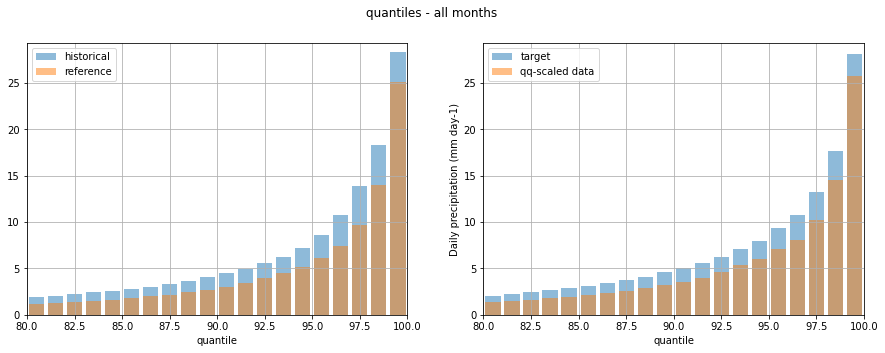

In [21]:
plot_city('Melbourne')

THREDBO


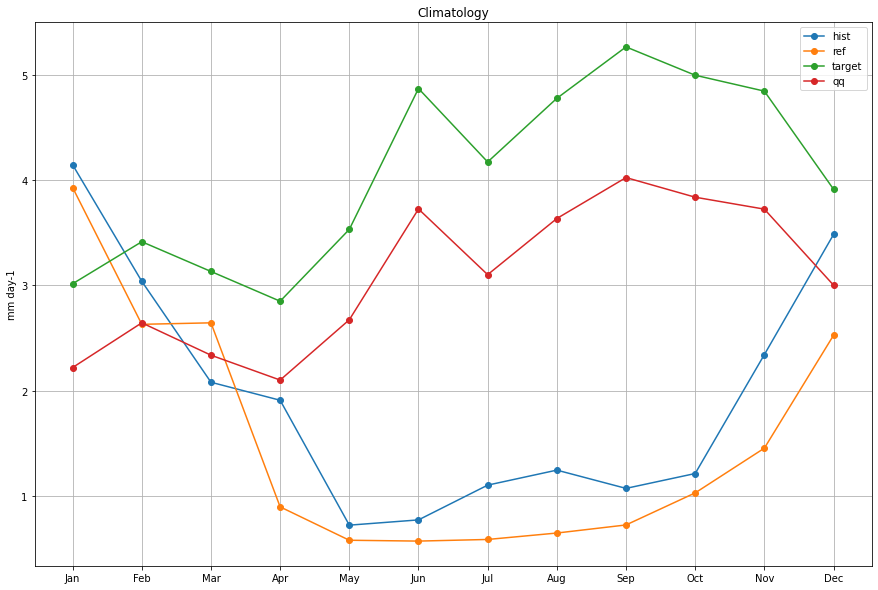

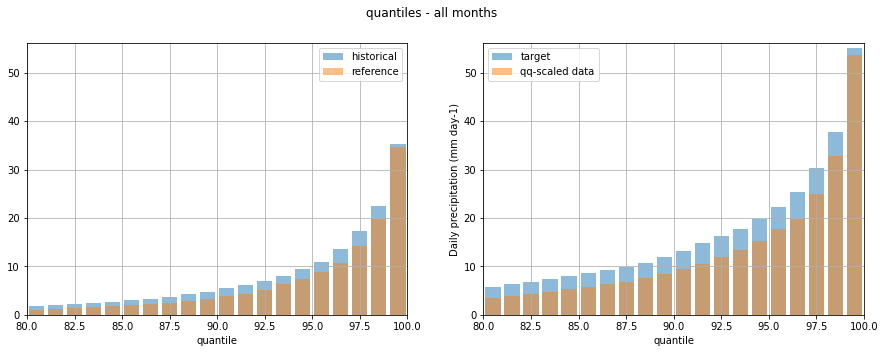

In [22]:
plot_city('Thredbo')

SYDNEY


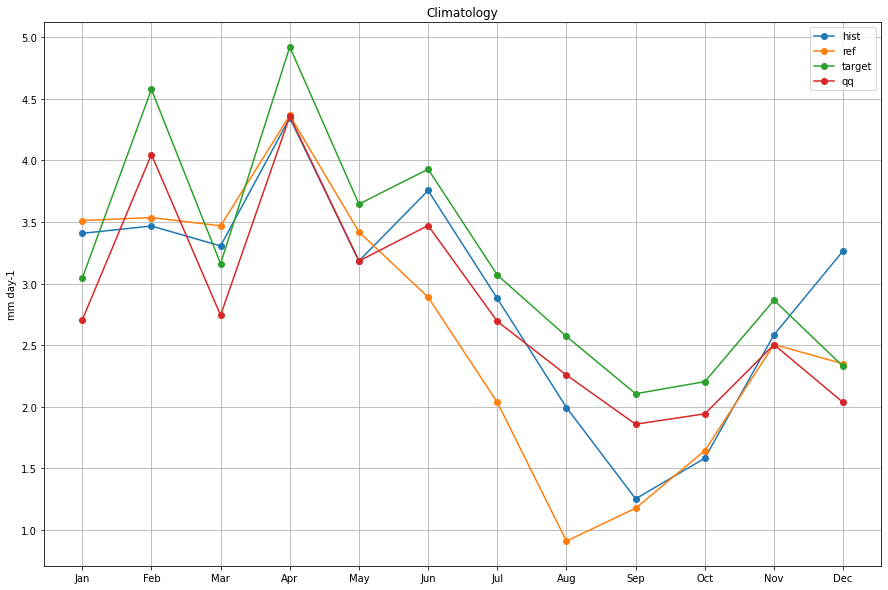

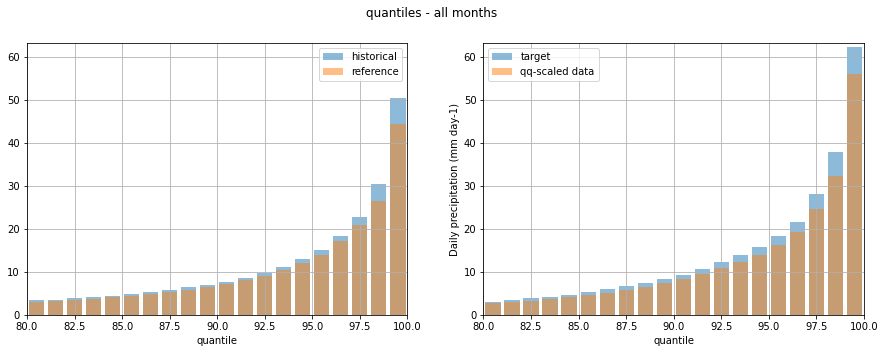

In [23]:
plot_city('Sydney')

BRISBANE


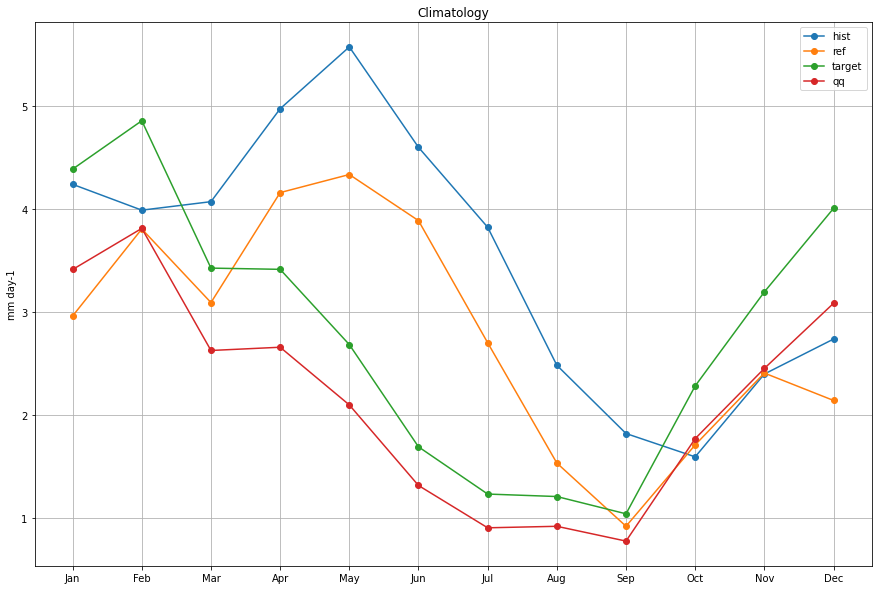

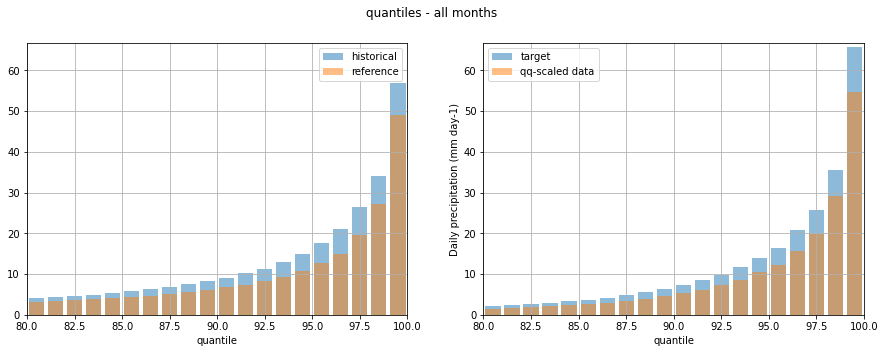

In [24]:
plot_city('Brisbane')

CAIRNS


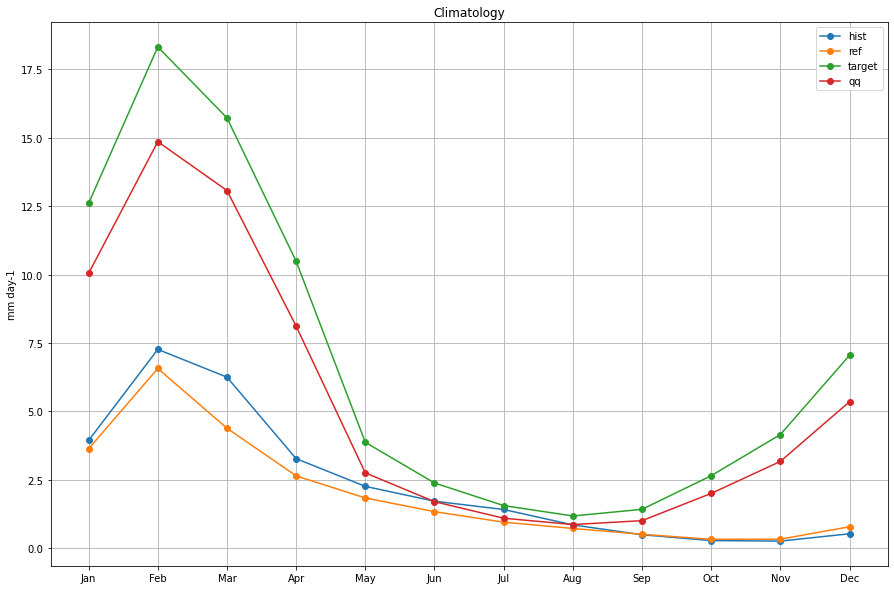

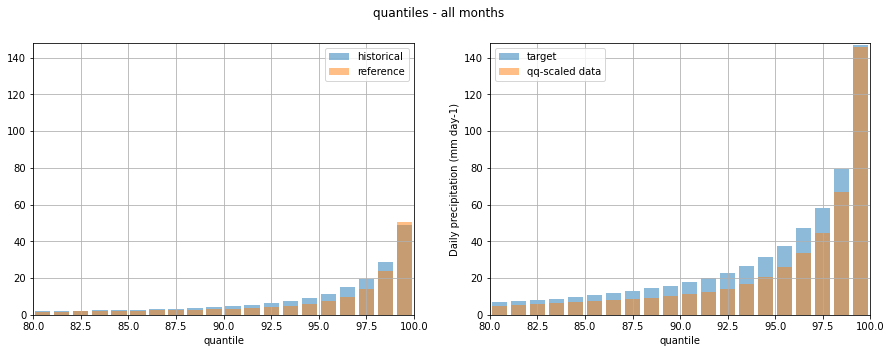

In [25]:
plot_city('Cairns')

DARWIN


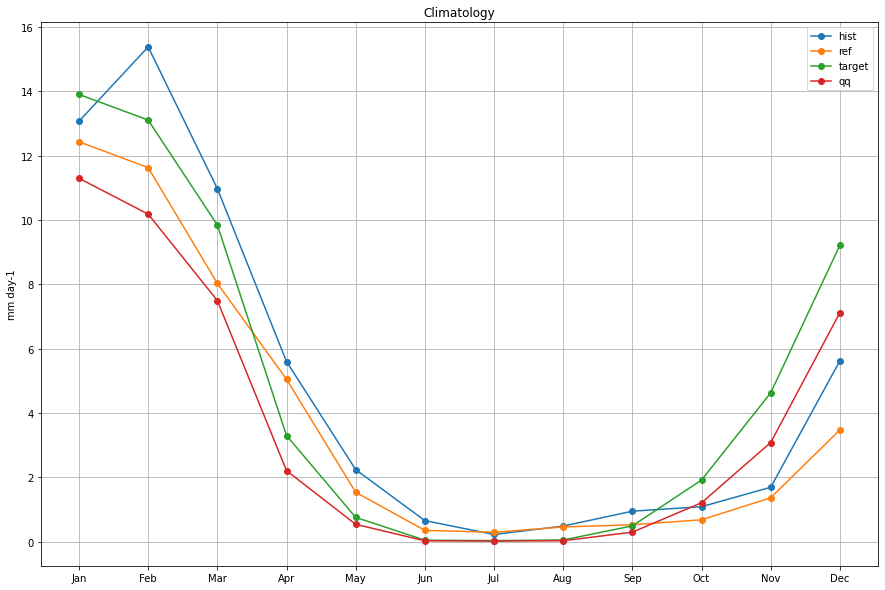

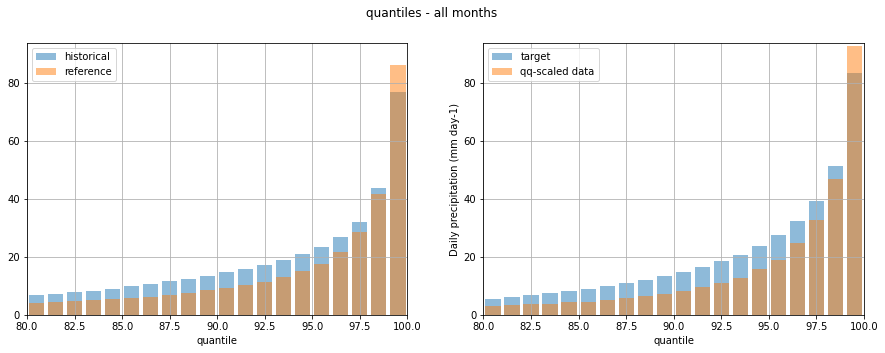

In [26]:
plot_city('Darwin')

ALICE SPRINGS


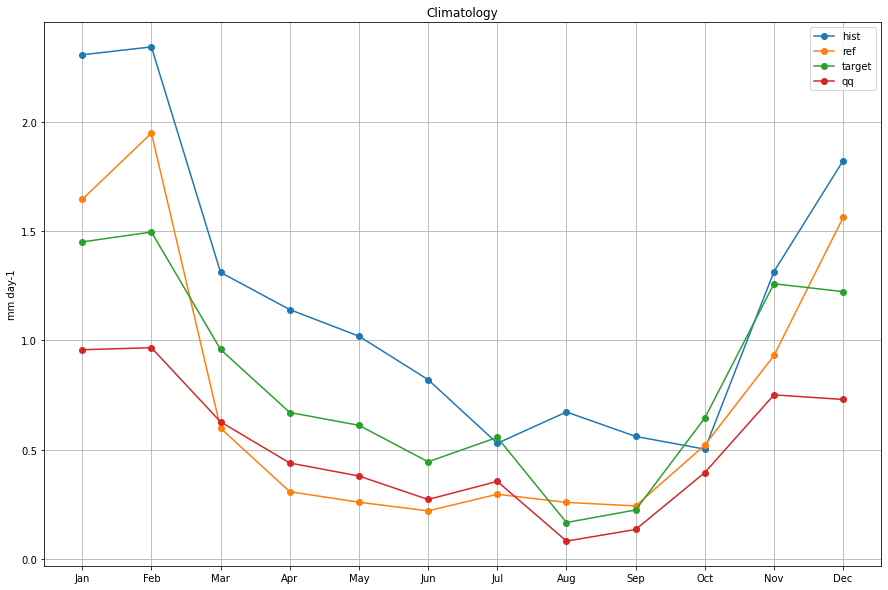

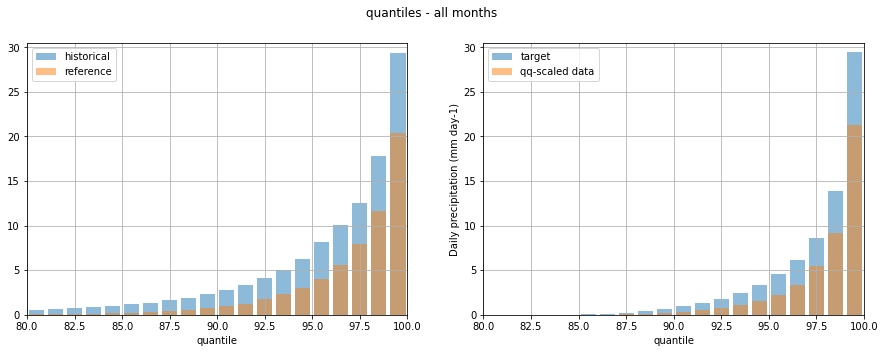

In [27]:
plot_city('Alice Springs')

PORT HEDLAND


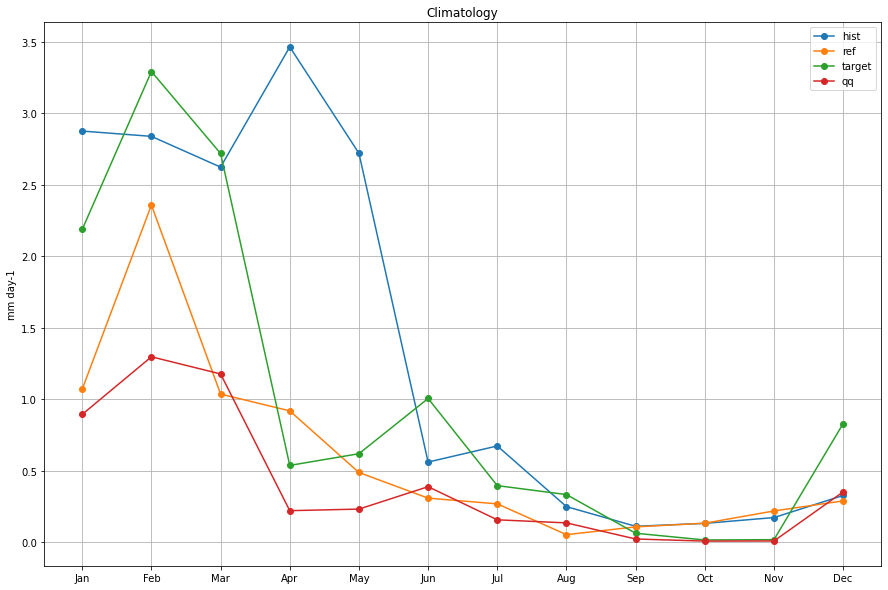

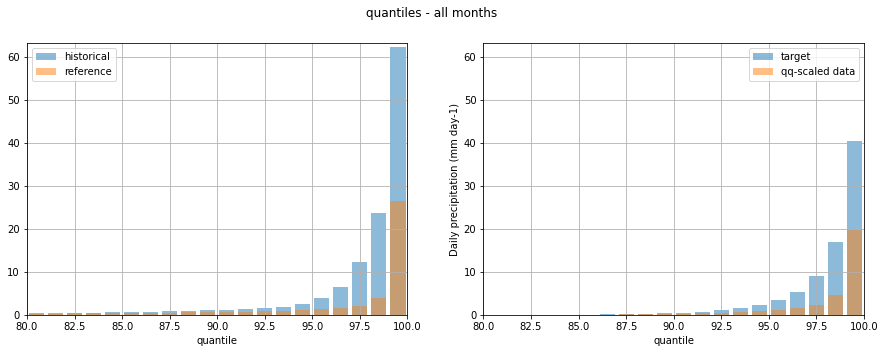

In [28]:
plot_city('Port Hedland')

PERTH


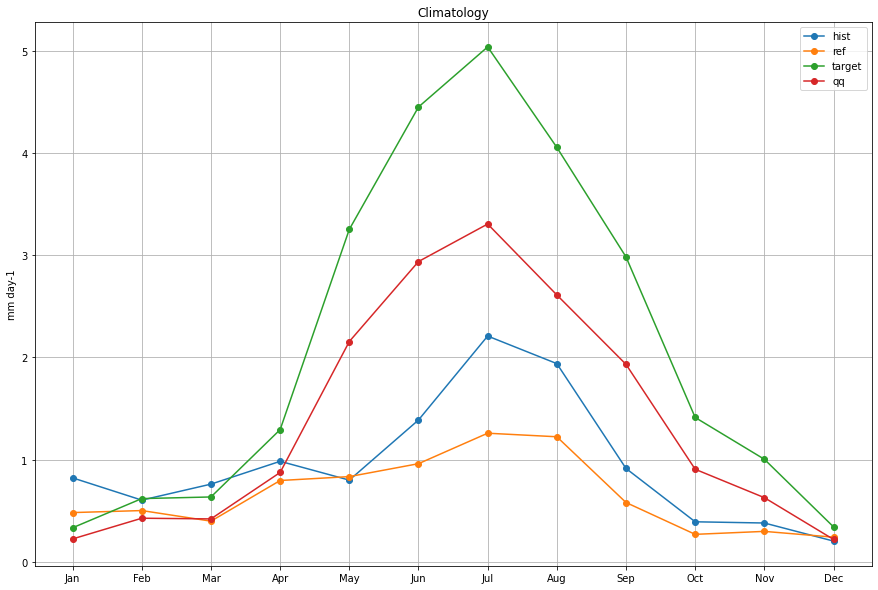

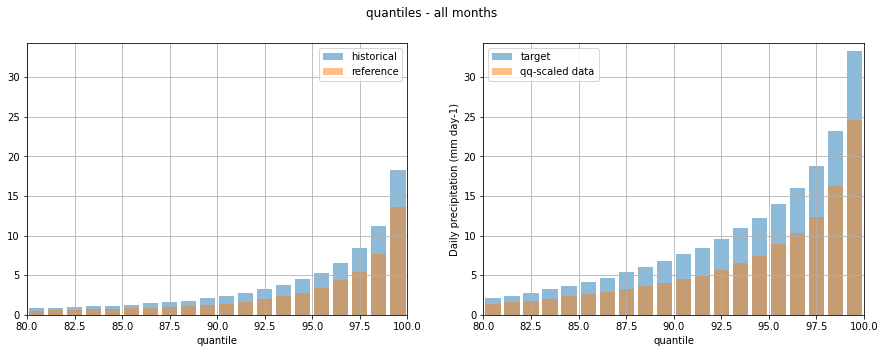

In [29]:
plot_city('Perth')